# correlation and RFE methods -- Titanic 

before doing feature selection, First, we should process titanic dataset 

## Process Titanic Dataset

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets

In [4]:
# loading data 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print('train_df:',train_df.shape, 'test_df:', test_df.shape)

train_df: (891, 12) test_df: (418, 11)


In [207]:
combined_df= pd.concat([train_df, test_df]) 
combined_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [208]:
print(combined_df.describe())
print(combined_df.info())

       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.020061    0.486592     0.837836    14.413493     1.041658   
min       1.000000    0.000000     1.000000     0.170000     0.000000   
25%     328.000000    0.000000     2.000000    21.000000     0.000000   
50%     655.000000    0.000000     3.000000    28.000000     0.000000   
75%     982.000000    1.000000     3.000000    39.000000     1.000000   
max    1309.000000    1.000000     3.000000    80.000000     8.000000   

             Parch         Fare  
count  1309.000000  1308.000000  
mean      0.385027    33.295479  
std       0.865560    51.758668  
min       0.000000     0.000000  
25%       0.000000     7.895800  
50%       0.000000    14.454200  
75%       0.000000    31.275000  
max       9.000000   512.329200  
<class 'pandas.core.frame.DataFrame'

In [209]:
combined_df['Age']=combined_df['Age'].fillna(combined_df['Age'].mean())
combined_df['Fare']=combined_df['Fare'].fillna(combined_df['Fare'].mean())
combined_df['Cabin']=combined_df['Cabin'].fillna('Unknow')
# combined_df['Cabin'].value_counts()
combined_df['Embarked'].value_counts()
combined_df['Embarked']=combined_df['Embarked'].fillna('S')

combined_df.Sex = combined_df.Sex.replace({'male':1,'female':0}).astype(np.uint8)

embarkedDF = pd.DataFrame()
embarkedDF = pd.get_dummies(combined_df['Embarked'],prefix='Embarked')

combined_df = pd.concat([combined_df,embarkedDF],axis=1)

combined_df = combined_df.drop(columns=['Embarked'])

pclassDf = pd.DataFrame()
pclassDf = pd.get_dummies(combined_df['Pclass'], prefix = 'Pclass')
combined_df = pd.concat([combined_df,pclassDf], axis=1)
combined_df = combined_df.drop(columns=['Pclass'])

titleDf = pd.DataFrame()
def getTitle(name):
    str1 = name.split(',')[1]
    str2 = str1.split('.')[0]
    str3 = str2.strip()
    return str3

titleDf['Title']= combined_df['Name'].map(getTitle)

title_mapDict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }
titleDf['Title'] = titleDf['Title'].map(title_mapDict)
titleDf = pd.get_dummies(titleDf['Title'])
combined_df = pd.concat([combined_df,titleDf],axis=1)
combined_df = combined_df.drop(columns=['Name'])

cabinDf = pd.DataFrame()
combined_df['Cabin'] = combined_df['Cabin'].map(lambda c : c[0])
cabinDf = pd.get_dummies(combined_df['Cabin'],prefix = 'Cabin' )
combined_df = pd.concat([combined_df,cabinDf],axis=1)
combined_df = combined_df.drop(columns=['Cabin'])

# new dataframe for family numbers include Parch, SibSp and self
familyDf = pd.DataFrame()
familyDf['FamilySize'] = combined_df['Parch'] + combined_df[ 'SibSp' ] + 1
familyDf['Family_Single'] = familyDf['FamilySize'].map( lambda s : 1 if s == 1 else 0 )
familyDf['Family_Small']  = familyDf['FamilySize'].map( lambda s : 1 if 2 <= s <= 4 else 0 )
familyDf['Family_Large']  = familyDf['FamilySize'].map( lambda s : 1 if 5 <= s else 0 )
combined_df = pd.concat([combined_df,familyDf],axis=1)

# survived 
SurvivedDf = pd.DataFrame()
SurvivedDf['Survived_new'] = combined_df['Survived'].fillna(0)
combined_df = pd.concat([combined_df, SurvivedDf], axis=1)
combined_df = combined_df.drop(columns=['Survived'])


combined_df.head()

# print(combined_df.dtypes) # 选X

,PassengerId,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large,Survived_new
0,1,1,22.0,1,0,A/5 21171,7.2500,0,0,1,...,0,0,0,0,1,2,0,1,0,0.0
1,2,0,38.0,1,0,PC 17599,71.2833,1,0,0,...,0,0,0,0,0,2,0,1,0,1.0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,...,0,0,0,0,1,1,1,0,0,1.0
3,4,0,35.0,1,0,113803,53.1000,0,0,1,...,0,0,0,0,0,2,0,1,0,1.0
4,5,1,35.0,0,0,373450,8.0500,0,0,1,...,0,0,0,0,1,1,1,0,0,0.0


In [210]:
print(len(combined_df['Ticket'].unique()))

929


In [211]:
combined_df.shape

(1309, 33)

In [212]:
combined_df['Ticket'].value_counts()

CA. 2343     11
1601          8
CA 2144       8
3101295       7
347082        7
             ..
8475          1
A/5 21173     1
220367        1
2623          1
4137          1
Name: Ticket, Length: 929, dtype: int64

In [213]:
combined_df.drop_duplicates()['Ticket'].value_counts()

CA. 2343     11
1601          8
CA 2144       8
3101295       7
347082        7
             ..
8475          1
A/5 21173     1
220367        1
2623          1
4137          1
Name: Ticket, Length: 929, dtype: int64

In [214]:
combined_df.loc[combined_df['Ticket']=='CA. 2343']

,PassengerId,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large,Survived_new
159,160,1,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
180,181,0,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
201,202,1,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
324,325,1,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
792,793,0,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
846,847,1,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
863,864,0,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
188,1080,0,29.881138,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
342,1234,1,29.881138,1,9,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0
360,1252,1,14.500000,8,2,CA. 2343,69.55,0,0,1,...,0,0,0,0,1,11,0,0,1,0.0


we can tell 'Ticket' feature is not meaningful. 1309 people have 929 different tickets. And there are 11 peopel use same ticket named 'CA.2343'. So we can drop this feature from our dataset. 
also, passengerId is not meaningful in this case. So we will drop this. 

In [215]:
combined_df = combined_df.drop(columns=['Ticket'])

In [216]:
combined_df = combined_df.drop(columns=['PassengerId'])

In [217]:
combined_df.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large,Survived_new
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,1,2,0,1,0,0.0
1,0,38.0,1,0,71.2833,1,0,0,1,0,...,0,0,0,0,0,2,0,1,0,1.0
2,0,26.0,0,0,7.9250,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,1.0
3,0,35.0,1,0,53.1000,0,0,1,1,0,...,0,0,0,0,0,2,0,1,0,1.0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0.0


## 1. Model one: correlation

In [218]:
corrDf = combined_df.corr()
corrDf.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large,Survived_new
Sex,1.000000,0.057397,-0.109609,-0.213125,-0.185484,-0.066564,-0.088651,0.115193,-0.107371,-0.028862,...,-0.040340,-0.006655,-0.083285,0.020558,0.137396,-0.188583,0.284537,-0.255196,-0.077748,-0.404020
Age,0.057397,1.000000,-0.190747,-0.130872,0.171521,0.076179,-0.012718,-0.059153,0.362587,-0.014193,...,0.106600,-0.072644,-0.085977,0.032461,-0.271918,-0.196996,0.116675,-0.038189,-0.161210,-0.060203
SibSp,-0.109609,-0.190747,1.000000,0.373587,0.160224,-0.048396,-0.048678,0.073709,-0.034256,-0.052419,...,-0.027180,-0.008619,0.006015,-0.013247,0.009064,0.861952,-0.591077,0.253590,0.699681,-0.014375
Parch,-0.213125,-0.130872,0.373587,1.000000,0.221522,-0.008635,-0.100943,0.071881,-0.013033,-0.010057,...,0.001084,0.020481,0.058325,-0.012304,-0.036806,0.792296,-0.549022,0.248532,0.624627,0.054908
Fare,-0.185484,0.171521,0.160224,0.221522,1.000000,0.286241,-0.130054,-0.169894,0.599956,-0.121372,...,0.073949,-0.037567,-0.022857,0.001179,-0.507197,0.226465,-0.274826,0.197281,0.170853,0.173630


In [219]:
corrDf['Survived_new'].sort_values(ascending =False)

Survived_new     1.000000
Miss             0.263140
Mrs              0.235600
Pclass_1         0.208166
Family_Small     0.202162
Fare             0.173630
Cabin_B          0.144226
Cabin_E          0.132654
Cabin_D          0.122592
Embarked_C       0.096513
Cabin_C          0.070323
Pclass_2         0.062279
Master           0.058265
Parch            0.054908
Royalty          0.036875
Cabin_F          0.034786
FamilySize       0.020555
Cabin_G          0.019554
Cabin_A          0.016938
Embarked_Q      -0.012730
Officer         -0.013356
SibSp           -0.014375
Cabin_T         -0.016444
Age             -0.060203
Embarked_S      -0.077095
Family_Large    -0.081979
Family_Single   -0.154285
Pclass_3        -0.231169
Cabin_U         -0.245239
Sex             -0.404020
Mr              -0.411211
Name: Survived_new, dtype: float64

In [220]:
# compare the correlation between features and remove one of two features that have a correlation higher than 0.5
X = combined_df.drop("Survived_new", axis=1)

columns = np.full((X.shape[1],),True, dtype=bool)

for i in range(X.shape[1]):
    for j in range(i+1,X.shape[1]):
        if abs(corrDf.iloc[i,j])>= 0.5:
            if columns[j]:
                columns[j] = False
                
selected_columns = X.columns[columns]

data = X
data = data[selected_columns]

print(selected_columns.values)

['Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked_C' 'Embarked_Q' 'Pclass_2'
 'Master' 'Officer' 'Royalty' 'Cabin_A' 'Cabin_B' 'Cabin_C' 'Cabin_D'
 'Cabin_E' 'Cabin_F' 'Cabin_G' 'Cabin_T']


In [221]:
combined_df_X = pd.concat([combined_df['Sex'],
                          combined_df['SibSp'], 
                          combined_df['Parch'], 
                          combined_df['Fare'], 
                          combined_df['Embarked_C'], 
                          combined_df['Embarked_Q'], 
                          combined_df['Pclass_2'], 
                          combined_df['Master'], 
                          combined_df['Officer'], 
                          combined_df['Royalty'], 
                          combined_df['Cabin_A'], 
                          combined_df['Cabin_B'], 
                          combined_df['Cabin_C'], 
                          combined_df['Cabin_D'], 
                          combined_df['Cabin_E'], 
                          combined_df['Cabin_F'], 
                          combined_df['Cabin_G'], 
                          combined_df['Cabin_T']], axis=1)
combined_df_X.head()

,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Pclass_2,Master,Officer,Royalty,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,1,0,7.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,71.2833,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,7.9250,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,53.1000,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,8.0500,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [222]:
sourceRow = 891
source_X = combined_df_X.iloc[0:sourceRow-1,:]
source_y = combined_df.iloc[0:sourceRow-1,-1] 

In [223]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(source_X ,
                                                    source_y,
                                                    train_size=0.8)

In [224]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit( train_X , train_y )
accuracy = model.score(test_X , test_y)
accuracy

/Users/xuechunwang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.848314606741573

since accuracy is 0.837 which is high enough, we can tell this feature selection is good. 

based on correlation feature selection, after data preprocessing, 'PassengerId' 'Sex' 'SibSp' 'Parch' 'Fare' 'Embarked_C' 'Embarked_Q'
 'Embarked_S' 'Pclass_3' 'Miss' 'Royalty' 'Cabin_A' 'Cabin_B' 'Cabin_C'
 'Cabin_D' 'Cabin_E' 'Cabin_F' 'Cabin_G' 'Cabin_T' 'Cabin_U' are fitting for. 

## 2. Model two: Recursive feature elimination

In [225]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [226]:
combined_df.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large,Survived_new
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,1,2,0,1,0,0.0
1,0,38.0,1,0,71.2833,1,0,0,1,0,...,0,0,0,0,0,2,0,1,0,1.0
2,0,26.0,0,0,7.9250,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,1.0
3,0,35.0,1,0,53.1000,0,0,1,1,0,...,0,0,0,0,0,2,0,1,0,1.0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0.0


In [228]:
X = combined_df.drop('Survived_new', axis=1)
y = combined_df['Survived_new']

from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8)

from sklearn.tree import DecisionTreeClassifier
# Build a logreg and compute the feature importances
model = DecisionTreeClassifier()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(train_X, train_y)

# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_S', 'Pclass_3', 'FamilySize']


/Users/xuechunwang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Optimal number of features: 11
Selected features: ['Sex', 'Pclass_3', 'Master', 'Miss', 'Mr', 'Officer', 'Cabin_B', 'Cabin_D', 'Cabin_E', 'Cabin_U', 'Family_Large']


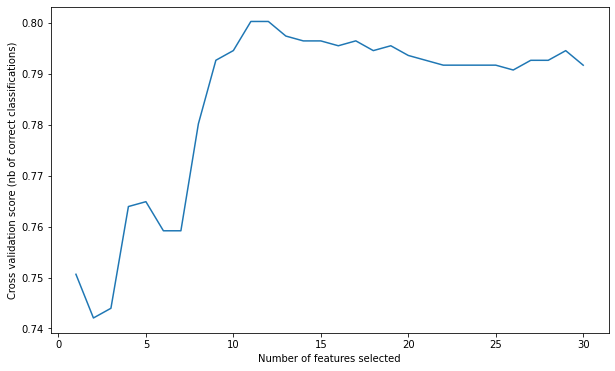

In [229]:
# RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features

from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(max_iter=1000), step=1, cv=10, scoring='accuracy')
rfecv.fit(train_X, train_y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

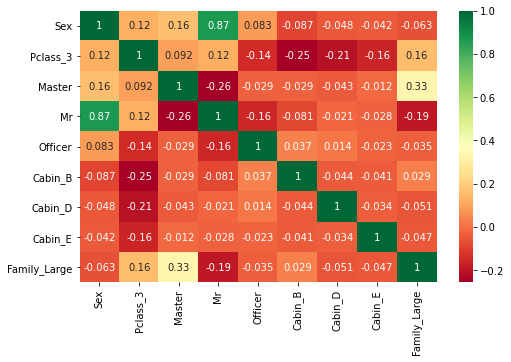

In [230]:
Selected_features = ['Sex', 'Pclass_3', 'Master', 'Mr', 'Officer', 'Cabin_B', 'Cabin_D', 'Cabin_E', 'Family_Large']

X = train_X[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()